In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo
import random as rn
import glob
import re

In [2]:
datadir='/cellar/users/snwright/Data/RareCommon/inputs/testing/'
resdir= '/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/testing/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/QTesting2_BinTh/'

In [433]:
import matplotlib
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

## Load data

In [4]:
file_lists = {'q_test': 2181779, 'q_control':2181417 , 'b_test':2181785, 'b_control':2181423}

In [5]:
'z1zz3'.split('z')

['', '1', '', '3']

In [6]:
z_suffs = []
for i in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
    for j in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
        if i >= j:
            z_suffs.append(f'z{i}zz{j}')

In [7]:
not_found = []
results = {}
for z,  job_id in file_lists.items():
    with open(os.path.join(resdir, f'{job_id}.files'), 'r') as f:
        filenames = [s.strip() for s in f.readlines()]
    filenames = set(filenames)
    loaded_data = []
    for f in tqdm(filenames):
        f_strip = f.split('.txt')[0]
        for suff in ['_bin5', '_bin10', '_bin20', '_bin40', '_bin80', '_bin160']:
            try:
                df = pd.read_csv(os.path.join(resdir,  f_strip+suff+'.txt'), 
                                 sep='\t', header=None, names=['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 
                             'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size'])
                df['param'] = 'bin'
                if suff == '':
                    df['value'] =  10
                else:
                    df['value'] = int(suff.split('bin')[-1])
                loaded_data.append(df)
            except FileNotFoundError:
                not_found.append(f_strip+suff+'.txt')
            
        for suff in z_suffs:
            try:
                df = pd.read_csv(os.path.join(resdir, f_strip+'_'+suff+'.txt'), 
                                 sep='\t', header=None, names=['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 
                             'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size'])
                df['param'] = 'th'
                df['value'] = suff.split('z')[1]
                df['value2'] = suff.split('z')[-1]
                loaded_data.append(df)
            except FileNotFoundError:
                not_found.append(f_strip+'_'+suff+'.txt')
        
    results[z] = pd.concat(loaded_data)
    results[z]['logp_nps'] = results[z].P_mean_NPS.apply(lambda x: -1 * np.log10(x+1e-250))
    results[z]['logp_size'] = results[z].P_size.apply(lambda x: -1 * np.log10(x+1e-250))
    results[z]['SizeOE'] = np.log2(results[z]['Size'] / results[z]['Null_Size'])
    results[z]['Set'] = z
    results[z]['FullTrait'] = results[z].apply(lambda a: '_'.join([a.TraitR, a.TraitC]), axis=1)

100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 51/51 [00:21<00:00,  2.38it/s]
/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 51/51 [00:21<00:00,  2.34it/s]
/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 51/51 [00:22<00:00,  2.29it/s]
/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)

In [8]:
all_results = pd.concat(results.values())

## Compare positive and negative examples

In [9]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import mannwhitneyu

def calculate_auc(df_in, value_col, processing_col, normalization_col, control_col, control_labels):
    """
    Calculate the AUC for each combination of processing and normalization methods.

    Args:
        df (pd.DataFrame): Input dataframe containing the data.
        value_col (str): Column containing the score values.
        processing_col (str): Column specifying input processing methods.
        normalization_col (str): Column specifying normalization methods.
        control_col (str): Column indicating positive/negative controls.
        control_labels (tuple): Tuple with positive and negative labels (e.g., ('positive', 'negative')).

    Returns:
        pd.DataFrame: AUC scores for each method combination.
    """
    results = []
    df = df_in.copy().dropna(subset=value_col)
    
    for (proc, norm), group in df.groupby([processing_col, normalization_col]):
        y_true = group[control_col].apply(lambda x: 1 if x == control_labels[0] else 0)
        try:
            auc_score = roc_auc_score(y_true, group[value_col])
        except:
            return y_true, group[value_col]
        results.append({
            processing_col: proc,
            normalization_col: norm,
            'AUC': auc_score
        })
    
    return pd.DataFrame(results)


def perform_mann_whitney(df_in, value_col, processing_col, normalization_col, control_col, control_labels):
    """
    Perform Mann-Whitney U test for each combination of processing and normalization methods.

    Args:
        df (pd.DataFrame): Input dataframe containing the data.
        value_col (str): Column containing the score values.
        processing_col (str): Column specifying input processing methods.
        normalization_col (str): Column specifying normalization methods.
        control_col (str): Column indicating positive/negative controls.
        control_labels (tuple): Tuple with positive and negative labels (e.g., ('positive', 'negative')).

    Returns:
        pd.DataFrame: Mann-Whitney U test statistics and p-values for each method combination.
    """
    results = []
    df = df_in.copy().dropna(subset=value_col)
    for (proc, norm), group in df.groupby([processing_col, normalization_col]):
        pos_scores = group[group[control_col] == control_labels[0]][value_col]
        neg_scores = group[group[control_col] == control_labels[1]][value_col]
        try:
            u_stat, p_value = mannwhitneyu(pos_scores, neg_scores, alternative='greater')
        except:
            return group, pos_scores, neg_scores
        results.append({
            processing_col: proc,
            normalization_col: norm,
            'U_statistic': u_stat,
            'p_value': p_value
        })
    
    return pd.DataFrame(results)


In [10]:
all_results['Method'] = all_results.Set.apply(lambda x: 'Q' if 'q' in x else 'B')
all_results['Test'] = all_results.Set.apply(lambda x: 'Test' if 'test' in x else 'Control')

In [11]:
all_results.columns

Index(['TraitR', 'TraitC', 'Network', 'Transform', 'Norm', 'Mean_NPS',
       'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size', 'param',
       'value', 'value2', 'logp_nps', 'logp_size', 'SizeOE', 'Set',
       'FullTrait', 'Method', 'Test'],
      dtype='object')

### Bin size

In [12]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
bin_res = []
for stat in stats:
    bin_df = all_results[all_results.param=='bin']

    auc = calculate_auc(bin_df, value_col=stat, processing_col='value', normalization_col='Method', 
                        control_col='Test', control_labels=('Test', 'Control'))
    mannu = perform_mann_whitney(bin_df, value_col=stat, processing_col='value', normalization_col='Method', 
                               control_col='Test', control_labels=('Test', 'Control'))
    res = auc.merge(mannu, on=['value', 'Method'], how='outer')
    res['stat'] = stat
    bin_res.append(res)
bin_results = pd.concat(bin_res)

,value,Method,AUC,U_statistic,p_value,stat
0,5,B,0.805766,1705.0,2.226803e-07,Mean_NPS
1,5,Q,0.805766,1705.0,2.226803e-07,Mean_NPS
2,10,B,0.801512,1696.0,3.209075e-07,Mean_NPS
3,10,Q,0.804820,1703.0,2.416169e-07,Mean_NPS
4,20,B,0.796786,1686.0,4.789366e-07,Mean_NPS


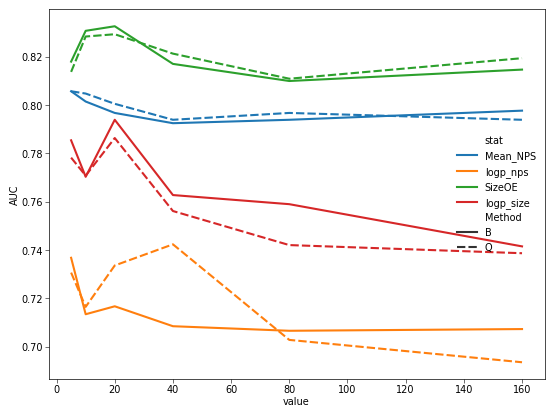

In [13]:
sns.lineplot(bin_results, x='value', y='AUC', hue='stat', style='Method')

bin_results.head()

In [14]:
all_results.head()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,param,value,value2,logp_nps,logp_size,SizeOE,Set,FullTrait,Method,Test
0,nearestGene_EFO_0004741_GCST008062,nearestGene_EFO_0004741_GCST008062,pcnet2_0,neglog10,sum,0.090069,0.000552,6.901000e-35,292,220.316,...,bin,5,NaN,34.161088,7.531062,0.406394,q_test,nearestGene_EFO_0004741_GCST008062_nearestGene...,Q,Test
0,nearestGene_EFO_0004741_GCST008062,nearestGene_EFO_0004741_GCST008062,pcnet2_0,neglog10,sum,0.092045,0.000375,1.002000e-33,296,230.428,...,bin,10,NaN,32.999132,5.852324,0.361281,q_test,nearestGene_EFO_0004741_GCST008062_nearestGene...,Q,Test
0,nearestGene_EFO_0004741_GCST008062,nearestGene_EFO_0004741_GCST008062,pcnet2_0,neglog10,sum,0.083334,0.000299,3.507000e-28,275,222.338,...,bin,20,NaN,27.455064,4.297311,0.306677,q_test,nearestGene_EFO_0004741_GCST008062_nearestGene...,Q,Test
0,nearestGene_EFO_0004741_GCST008062,nearestGene_EFO_0004741_GCST008062,pcnet2_0,neglog10,sum,0.100215,-0.000327,1.131000e-42,278,213.371,...,bin,40,NaN,41.946537,5.747390,0.381721,q_test,nearestGene_EFO_0004741_GCST008062_nearestGene...,Q,Test
0,nearestGene_EFO_0004741_GCST008062,nearestGene_EFO_0004741_GCST008062,pcnet2_0,neglog10,sum,0.072214,-0.000296,4.469000e-24,223,194.007,...,bin,80,NaN,23.349790,1.640924,0.200935,q_test,nearestGene_EFO_0004741_GCST008062_nearestGene...,Q,Test


/tmp/ipykernel_615689/2365819726.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axa.set_yticklabels(['', 0.5, 1, 2, 4])


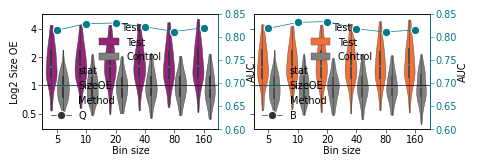

In [15]:
_, [axa, axb] = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(5,1.5))

sns.violinplot(all_results[(all_results.param=='bin') & (all_results.Method=='Q')].reset_index(), x='value', y='SizeOE', hue='Test', cut=0,
              palette=['#97247C', 'grey'], ax=axa, saturation=1)
axa.hlines(y=0, xmin=-0.5, xmax=5.5, color='black', linewidth=0.5)
axa.set_xlim(-0.5, 5.5)
ax2 = axa.twinx()
bin_results['plotx'] = bin_results.value.map({5:0, 10:1, 20:2, 40:3, 80:4, 160:5})
sns.lineplot(bin_results[(bin_results.stat=='SizeOE') & (bin_results.Method=='Q')], x='plotx', y='AUC', hue='stat', style='Method', ax=ax2, markers=True,
            palette=['#00798C'], linewidth=0.5)
ax2.set_ylim(0.6, 0.85)
ax2.tick_params(axis='y', colors='#00798C')
ax2.spines['right'].set_color('#00798C')
axa.set_xlabel('Bin size')
axa.set_ylabel('Log2 Size OE')
axa.set_yticklabels(['', 0.5, 1, 2, 4])


sns.violinplot(all_results[(all_results.param=='bin') & (all_results.Method=='B')].reset_index(), x='value', y='SizeOE', hue='Test', cut=0,
              palette=['#F36F38', 'grey'], ax=axb, saturation=1)
axb.hlines(y=0, xmin=-0.5, xmax=5.5, color='black', linewidth=0.5)
axb.set_xlim(-0.5, 5.5)
ax3 = axb.twinx()
bin_results['plotx'] = bin_results.value.map({5:0, 10:1, 20:2, 40:3, 80:4, 160:5})
sns.lineplot(bin_results[(bin_results.stat=='SizeOE') & (bin_results.Method=='B')], x='plotx', y='AUC', hue='stat', style='Method', ax=ax3, markers=True,
            palette=['#00798C'], linewidth=0.5)
ax3.set_ylim(0.6, 0.85)
ax3.tick_params(axis='y', colors='#00798C')
ax3.spines['right'].set_color('#00798C')
axb.set_xlabel('Bin size')

plt.savefig(os.path.join(figdir, 'optimize_bin_sizeOE.svg'), bbox_inches='tight')

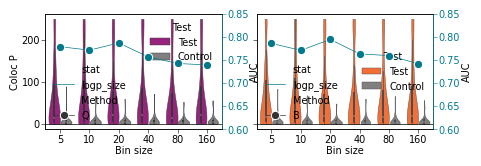

In [16]:
_, [axa, axb] = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(5,1.5))

sns.violinplot(all_results[(all_results.param=='bin') & (all_results.Method=='Q')].reset_index(), x='value', 
               y='logp_size', hue='Test', cut=0,
              palette=['#97247C', 'grey'], ax=axa, saturation=1)
axa.hlines(y=0, xmin=-0.5, xmax=5.5, color='black', linewidth=0.5)
axa.set_xlim(-0.5, 5.5)
ax2 = axa.twinx()
bin_results['plotx'] = bin_results.value.map({5:0, 10:1, 20:2, 40:3, 80:4, 160:5})
sns.lineplot(bin_results[(bin_results.stat=='logp_size') & (bin_results.Method=='Q')], x='plotx', y='AUC', 
             hue='stat', style='Method', ax=ax2, markers=True,
            palette=['#00798C'], linewidth=0.5)
ax2.set_ylim(0.6, 0.85)
ax2.tick_params(axis='y', colors='#00798C')
ax2.spines['right'].set_color('#00798C')
axa.set_xlabel('Bin size')
axa.set_ylabel('Coloc P')


sns.violinplot(all_results[(all_results.param=='bin') & (all_results.Method=='B')].reset_index(), x='value',
               y='logp_size', hue='Test', cut=0,
              palette=['#F36F38', 'grey'], ax=axb, saturation=1)
axb.hlines(y=0, xmin=-0.5, xmax=5.5, color='black', linewidth=0.5)
axb.set_xlim(-0.5, 5.5)
ax3 = axb.twinx()
bin_results['plotx'] = bin_results.value.map({5:0, 10:1, 20:2, 40:3, 80:4, 160:5})
sns.lineplot(bin_results[(bin_results.stat=='logp_size') & (bin_results.Method=='B')], x='plotx', y='AUC', 
             hue='stat', style='Method', ax=ax3, markers=True,
            palette=['#00798C'], linewidth=0.5)
ax3.set_ylim(0.6, 0.85)
ax3.tick_params(axis='y', colors='#00798C')
ax3.spines['right'].set_color('#00798C')
axb.set_xlabel('Bin size')
plt.savefig(os.path.join(figdir, 'optimize_bin_pval.svg'), bbox_inches='tight')

### Thresholds

In [17]:
all_results['Threshold'] = [x for x in zip(all_results.value, all_results.value2)]

In [18]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
th_res = []
for stat in stats:
    th_df = all_results[all_results.param=='th']
    if stat in ['SizeOE', 'logp_size']:
        th_df = th_df[th_df.Size > 0]

    auc = calculate_auc(th_df, value_col=stat, processing_col='Threshold', normalization_col='Method', 
                        control_col='Test', control_labels=('Test', 'Control'))
    mannu = perform_mann_whitney(th_df, value_col=stat, processing_col='Threshold', normalization_col='Method', 
                               control_col='Test', control_labels=('Test', 'Control'))
    res = auc.merge(mannu, on=['Threshold', 'Method'], how='outer')
    res['stat'] = stat
    th_res.append(res)
th_results = pd.concat(th_res)

In [19]:
th_results['ThZ'] = th_results.Threshold.apply(lambda x: x[0]) 
th_results['ThZZ'] = th_results.Threshold.apply(lambda x: x[1]) 

In [20]:
th_results['logp'] = np.log10(th_results.p_value) * -1

In [21]:
th_results[th_results.stat=='SizeOE'].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1]

ThZ,1,1.5,2,2.5,3,3.5,4
ThZZ,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,0.590133
3.5,NaN,NaN,NaN,NaN,NaN,0.598884,0.595058
3,NaN,NaN,NaN,NaN,0.690382,0.693176,0.691217
2.5,NaN,NaN,NaN,0.777410,0.778592,0.780009,0.778119
2,NaN,NaN,0.800567,0.799622,0.800331,0.801040,0.800095
1.5,NaN,0.831522,0.831994,0.830340,0.827977,0.825614,0.819943
1,0.845463,0.844754,0.833412,0.832231,0.831994,0.828686,0.823015


In [22]:
import matplotlib.colors as mcolors
cmapx = mcolors.LinearSegmentedColormap.from_list("my_cmap", ['#F5D1A0','#F08E02', '#BD6E01'])

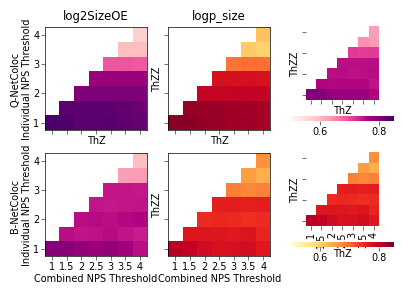

In [23]:
_, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, figsize=(4.5, 3), sharex=True, sharey=True)

sns.heatmap(th_results[(th_results.stat=='SizeOE') & (th_results.Method=='Q')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax1, cmap='RdPu', square=True, vmax=0.85, vmin=0.5, cbar=False)
sns.heatmap(th_results[(th_results.stat=='logp_size') & (th_results.Method=='Q')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax4, cmap='RdPu', square=True, vmax=0.85, vmin=0.5, cbar=False)
sns.heatmap(th_results[th_results.stat=='logp_size'].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax3, cmap='RdPu', square=True, vmax=0.85, vmin=0.5, cbar=True,cbar_kws={'shrink':1, 'orientation':'horizontal'} )


sns.heatmap(th_results[(th_results.stat=='SizeOE') & (th_results.Method=='B')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax2, cmap='YlOrRd', square=True, vmax=0.85, vmin=0.5, cbar=False)
sns.heatmap(th_results[(th_results.stat=='logp_size') & (th_results.Method=='B')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax5, cmap='YlOrRd', square=True, vmax=0.85, vmin=0.5, cbar=False)
sns.heatmap(th_results[(th_results.stat=='logp_size') & (th_results.Method=='B')].reset_index().pivot_table(columns='ThZ', index='ThZZ', values='AUC').iloc[::-1], 
            ax=ax6, cmap='YlOrRd', square=True, vmax=0.85, vmin=0.5, cbar=True, cbar_kws={'shrink':1, 'orientation':'horizontal'})

for ax in [ax1, ax2, ax4, ax5]:
    for spine in ax.spines.values():
        spine.set_visible(True)      # Ensure the spine is visible         # Set the thickness of the border
        spine.set_edgecolor('black')  

ax4.set_xlabel('Combined NPS Threshold')
ax5.set_xlabel('Combined NPS Threshold')
ax1.set_ylabel('Q-NetColoc\nIndividual NPS Threshold')
ax4.set_ylabel('B-NetColoc\nIndividual NPS Threshold')
ax1.tick_params(axis='y', rotation=0)
ax4.tick_params(axis='y', rotation=0)
ax1.set_title('log2SizeOE')
ax2.set_title('logp_size')
plt.savefig(os.path.join(figdir, 'optimize_th_heatmaps.svg'), bbox_inches='tight')

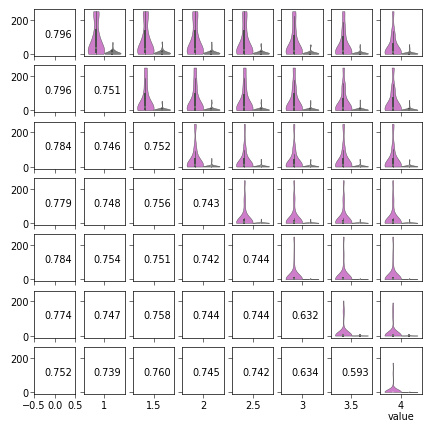

In [24]:
_, axs = plt.subplots(nrows=7, ncols=8, figsize=(5,5), sharey=True, sharex='col')

for x, i in enumerate([1, 1.5, 2, 2.5, 3, 3.5, 4]):
    for y, j in enumerate([1, 1.5, 2, 2.5, 3, 3.5, 4]):
        if i >= j:
            sns.violinplot(all_results[(all_results.param=='th') & (all_results.Method=='Q') & (all_results.value==str(i)) & (all_results.value2==str(j))].reset_index(), x='value', 
               y='logp_size', hue='Test', cut=0, legend=False, 
              palette=['orchid', 'grey'], ax=axs[y][x+1])
        if i <= j:
            axs[y][x].annotate(xy=(-0.25,100), text=f'{th_results[(th_results.stat=="logp_size") & (th_results.Method=="Q") & (th_results.ThZ==str(j)) & (th_results.ThZZ==str(i))].AUC.values[0]:.3f}')
            if x == 0:
                axs[y][x].set_xlim(-0.5, 0.5)

(-0.5, 6.5)

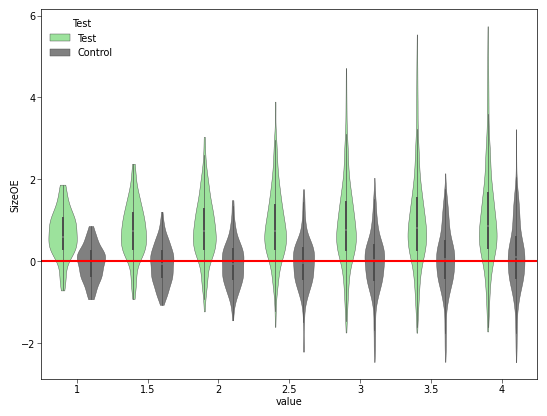

In [27]:
sns.violinplot(all_results[all_results.param=='th'].reset_index(), x='value', y='SizeOE', hue='Test', cut=0,
              palette=['lightgreen', 'grey'])
plt.hlines(y=0, xmin=-0.5, xmax=6.5, color='red')
plt.xlim(-0.5, 6.5)

(-0.5, 6.5)

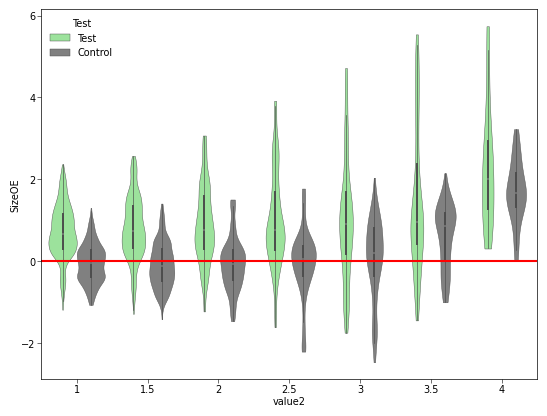

In [28]:
sns.violinplot(all_results[all_results.param=='th'].reset_index(), x='value2', y='SizeOE', hue='Test', cut=0,
              palette=['lightgreen', 'grey'])
plt.hlines(y=0, xmin=-0.5, xmax=6.5, color='red')
plt.xlim(-0.5, 6.5)

## SNP-to-Gene + p Threshold

### Load data

In [129]:
file_lists = {'nearestGene': { 'sum':2181779, 'binary':2181785},
             'nearestGeneTH8': { 'sum':2182650, 'binary':2182651},
             'magma_th104':{ 'sum':2194408, 'binary':2194396},
             'magma_th256': { 'sum':2182655, 'binary':2182656}}
results = {x: {} for x in file_lists}

In [130]:
resdir

'/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/testing/'

In [190]:
not_found = []
for x, y in file_lists.items():
    print(x)
    for z,  job_id in y.items():
        if 'magma' in x:
            with open(os.path.join(resdir,'../magma', f'{job_id}.files'), 'r') as f:
                filenames = list(set([s.strip() for s in f.readlines()]))
            loaded_data = []
            for f in filenames:
                f = f.replace('.txt', '_bin20.txt')
                try:
                    loaded_data.append(pd.read_csv(os.path.join(resdir, '../magma', f), sep='\t', header=None))
                except FileNotFoundError:
                    try:
                        f = f.replace('_bin20.txt', '.txt')
                        loaded_data.append(pd.read_csv(os.path.join(resdir, '../magma', f), sep='\t', header=None))
                    except:
                        not_found.append(os.path.join(resdir, '../magma', f))
        else:
            with open(os.path.join(resdir, f'{job_id}.files'), 'r') as f:
                filenames = list(set([s.strip() for s in f.readlines()]))
            loaded_data = []
            for f in filenames:
                f = f.replace('.txt', '_bin20.txt')
                try:
                    loaded_data.append(pd.read_csv(os.path.join(resdir, f), sep='\t', header=None))
                except FileNotFoundError:
                    not_found.append(f)
        results[x][z] = pd.concat(loaded_data)
        results[x][z].columns = ['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 
                                 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
        results[x][z]['Group'] = x
        results[x][z]['Norm'] = z
        results[x][z]['logp_nps'] = results[x][z].P_mean_NPS.apply(lambda x: -1 * np.log10(x+1e-250))
        results[x][z]['logp_size'] = results[x][z].P_size.apply(lambda x: -1 * np.log10(x+1e-250))
        results[x][z]['SizeOE'] = np.log2(results[x][z]['Size'] / results[x][z]['Null_Size'])
        results[x][z]['Set'] = 'Test'
        results[x][z]['FullTrait'] = results[x][z].apply(lambda a: '_'.join([a.TraitR, a.TraitC]), axis=1)

nearestGene
nearestGeneTH8
magma_th104
magma_th256


In [132]:
ng = pd.concat(results['nearestGene'].values())
ng8 = pd.concat(results['nearestGeneTH8'].values())
mag104 = pd.concat(results['magma_th104'].values())
mag256 = pd.concat(results['magma_th256'].values())

In [217]:
control_lists = {'nearestGene': { 'sum':2221434, 'binary':2221426},
             'nearestGeneTH8': { 'sum':2182653, 'binary':2182652},
             'magma_th104':{ 'sum': 2221406, 'binary':2221413},
             'magma_th256': { 'sum':2182659, 'binary':2182657}}
control_results = {x: {} for x in control_lists}

In [216]:
resdir

'/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/testing/'

In [218]:
not_found = []
for x, y in control_lists.items():
    print(x)
    for z,  job_id in y.items():
        if 'magma' in x:
            with open(os.path.join(resdir,'../magma', f'{job_id}.files'), 'r') as f:
                filenames = list(set([s.strip() for s in f.readlines()]))
            
            loaded_data = []
            for f in filenames:
                f = f.replace('.txt', '_bin20.txt')
                try:
                    loaded_data.append(pd.read_csv(os.path.join(resdir, '../magma', f), sep='\t', header=None))
                except FileNotFoundError:
                    try:
                        f = f.replace('_bin20.txt', '.txt')
                        loaded_data.append(pd.read_csv(os.path.join(resdir, '../magma', f), sep='\t', header=None))
                    except:
                        not_found.append(os.path.join(resdir, '../magma', f))
        else:
            with open(os.path.join(resdir, f'{job_id}.files'), 'r') as f:
                filenames = list(set([s.strip() for s in f.readlines()]))
            loaded_data = []
            for f in filenames:
                try:
                    loaded_data.append(pd.read_csv(os.path.join(resdir, f), sep='\t', header=None))
                except FileNotFoundError:
                    try:
                        f = f.replace('.txt', '_bin20.txt')
                        loaded_data.append(pd.read_csv(os.path.join(resdir, f), sep='\t', header=None))
                    except:
                        not_found.append(f)
        control_results[x][z] = pd.concat(loaded_data)
        control_results[x][z].columns = ['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 
                                 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
        control_results[x][z]['Group'] = x
        control_results[x][z]['Norm'] = z
        control_results[x][z]['logp_nps'] = control_results[x][z].P_mean_NPS.apply(lambda x: -1 * np.log10(x+1e-250))
        control_results[x][z]['logp_size'] = control_results[x][z].P_size.apply(lambda x: -1 * np.log10(x+1e-250))
        control_results[x][z]['SizeOE'] = np.log2(control_results[x][z]['Size'] / control_results[x][z]['Null_Size'])
        control_results[x][z]['Set'] = 'Control'
        control_results[x][z]['FullTrait'] = control_results[x][z].apply(lambda a: '_'.join([a.TraitR, a.TraitC]), axis=1)

nearestGene
nearestGeneTH8
magma_th104
magma_th256


In [220]:
ng_cont = pd.concat(control_results['nearestGene'].values())
ng8_cont = pd.concat(control_results['nearestGeneTH8'].values())
mag104_cont = pd.concat(control_results['magma_th104'].values())
mag256_cont = pd.concat(control_results['magma_th256'].values())

In [221]:
all_df = pd.concat([ng, ng8, mag104, mag256,ng_cont, ng8_cont, mag104_cont, mag256_cont])

In [222]:
def clean_trait(x):
    # replace magma_
    x = x.replace('magma_', 'magma')
    return x.split('_', 1)[-1]

import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    return None


all_df['CleanTrait'] = all_df.apply(lambda x: '_'.join([clean_trait(x.TraitR), clean_trait(x.TraitC)]), axis=1)
all_df['StudyR'] = all_df.TraitR.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
all_df['StudyC'] = all_df.TraitC.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
all_df['EFOR'] = all_df.TraitR.apply(lambda x: map_trait_code(x))
all_df['EFOC'] = all_df.TraitC.apply(lambda x: map_trait_code(x))
all_df['testID'] = all_df['StudyR'] + all_df['StudyC'] + all_df['EFOR'] + all_df['EFOC']

### Association p threshold

In [223]:
df1 = all_df[all_df.Group == 'nearestGene']
df2 = all_df[all_df.Group == 'nearestGeneTH8']
shared_tests = set(df1.testID.unique()).intersection(set(df2.testID.unique()))
n=len(shared_tests)
controls1 = df1[df1.Set=='Control'].sort_values('testID').iloc[0:2*n]
controls2 = df2[df2.Set=='Control'].sort_values('testID').iloc[0:2*n]
df1 = pd.concat([df1[(df1.testID.isin(shared_tests))], controls1])
df2 = pd.concat([df2[(df2.testID.isin(shared_tests))], controls2])
auc = calculate_auc(pd.concat([df1, df2]), value_col='SizeOE', processing_col='Group', normalization_col='Norm', 
                            control_col='Set', control_labels=('Test', 'Control'))
auc

,Group,Norm,AUC
0,nearestGene,binary,0.837288
1,nearestGene,sum,0.836158
2,nearestGeneTH8,binary,0.823729
3,nearestGeneTH8,sum,0.817514


In [204]:
all_df.groupby(['Group', 'Norm']).Set.value_counts().reset_index()

,Group,Norm,Set,count
0,magma_th104,binary,Test,61
1,magma_th104,binary,Control,35
2,magma_th104,sum,Test,61
3,magma_th104,sum,Control,31
4,magma_th256,binary,Test,48
5,magma_th256,binary,Control,45
6,magma_th256,sum,Test,48
7,magma_th256,sum,Control,45
8,nearestGene,binary,Test,46
9,nearestGene,binary,Control,2


In [340]:
def pair_auc(df1, df2, stats=['Mean_NPS', 'SizeOE', 'logp_size', 'logp_nps'], comp1='Group', comp2='Norm'):
    auc_res = []
    for stat in stats:
        shared_tests = set(df1[df1.Set=='Test'].testID.unique()).intersection(set(df2[df2.Set=='Test'].testID.unique()))
        shared_controls = set(df1[df1.Set=='Control'].testID.unique()).intersection(set(df2[df2.Set=='Control'].testID.unique()))
        n=len(shared_tests)
        #controls1 = df1[df1.Set=='Control'].sort_values('testID').iloc[0:2*n]
        #controls2 = df2[df2.Set=='Control'].sort_values('testID').iloc[0:2*n]
        df1 = pd.concat([df1[(df1.testID.isin(shared_tests))], df1[(df1.testID.isin(shared_controls))]])
        df2 = pd.concat([df2[(df2.testID.isin(shared_tests))], df2[(df2.testID.isin(shared_controls))]])
        test_df = pd.concat([df1, df2])
        if stat == 'logp_size':
            test_df['logp_size'] = test_df.apply(lambda z: z.logp_size if z.SizeOE> 0 else -1 * z.logp_size, axis=1)
        
        auc = calculate_auc(test_df, value_col=stat, processing_col=comp1, normalization_col=comp2, 
                                    control_col='Set', control_labels=('Test', 'Control'))
        mannu = perform_mann_whitney(test_df, value_col=stat, processing_col=comp1, normalization_col=comp2, 
                                   control_col='Set', control_labels=('Test', 'Control'))
        res = auc.merge(mannu, on=[comp1, comp2], how='outer')
        res['stat'] = stat
        auc_res.append(res)
    return pd.concat(auc_res), test_df

ng_th, ng_th_df = pair_auc(all_df[all_df.Group == 'nearestGene'], all_df[all_df.Group == 'nearestGeneTH8'])
magma_th, magma_th_df = pair_auc(all_df[all_df.Group == 'magma_th104'], all_df[all_df.Group == 'magma_th256'])

In [334]:
ng_th_df.groupby(['Group', 'Norm']).Set.value_counts()

Group           Norm    Set    
nearestGene     binary  Test       30
                        Control    29
                sum     Test       30
                        Control    29
nearestGeneTH8  binary  Test       30
                        Control    29
                sum     Test       30
                        Control    29
Name: count, dtype: int64

In [335]:
magma_th_df.groupby(['Group', 'Norm']).Set.value_counts()

Group        Norm    Set    
magma_th104  binary  Test       48
                     Control    45
             sum     Test       48
                     Control    44
magma_th256  binary  Test       48
                     Control    45
             sum     Test       48
                     Control    45
Name: count, dtype: int64

In [336]:
res_df= ng_th
res_df[(res_df.Group=='nearestGene') & (res_df.Norm=='binary') & (res_df.stat=='logp_size')].AUC.values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [337]:
def plot_pair_auc(res_df, plot_df, ax=None, group='Group', stat='logp_size', group_col='Group', group2_col='Norm', 
                  color='lightgreen', text_p = False, text_n=False):
    sns.violinplot(plot_df[plot_df[group_col]==group], y=stat, x=group2_col, hue='Set',cut=0, linewidth=0.5, 
                   palette=[color, 'grey'],  zorder=1, legend=False, ax=ax, saturation=1)
    for j, norm in enumerate(plot_df[group2_col].unique()):
        
        auc = float('%.3g' % res_df[(res_df[group_col]==group) & (res_df[group2_col]==norm) & (res_df.stat==stat)].AUC.values[0])
        if text_p:
            p = float('%.2g' % res_df[(res_df[group_col]==group) & (res_df[group2_col]==norm) & (res_df.stat==stat)].p_value.values[0])
            ax.text(x=j-0.1, y=plot_df[stat].max()*0.9, s=f'AUC:{auc}\np:{p}', fontsize=7)
        elif text_n:
            n = int(plot_df[plot_df[group_col]==group].groupby(group2_col).Set.value_counts().values[0])
            ax.text(x=j-0.1, y=plot_df[stat].max()*0.9, s=f'AUC:{auc}\nn={n}', fontsize=7)
        else:
            ax.text(x=j-0.1, y=plot_df[stat].max()*0.9, s=f'AUC:{auc}', fontsize=7)
    if (stat == 'SizeOE') or (stat=='log2SizeOE'):
        _ = ax.set_yticks([-1, 0, 1, 2, 3], [0.5, 1, 2, 4, 8])
        _ = ax.set_yticks(np.log2([3,5,6,7]), minor=True)
    
    testId_counts =  plot_df[plot_df[group_col]==group].groupby(group2_col).Set.value_counts()
    minor_label = []
    for g in plot_df[plot_df[group_col]==group][group2_col].unique():
        for s in ['Test', 'Control']:
            minor_label.append(f'n={testId_counts[g][s]}')
    
    ax.set_xticks([-0.2,  0.2, 0.8, 1.2], labels=minor_label, minor=True)
    
    return plot_df[plot_df[group_col]==group]

Text(0.5, 0, 'B-NetColoc')

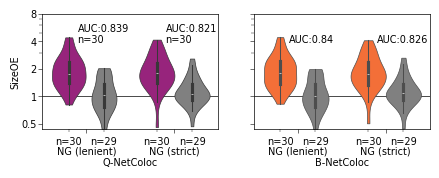

In [342]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(5,1.5), sharey=True)    

a = plot_pair_auc(ng_th, ng_th_df, ax=ax1, group='sum', stat='SizeOE', group_col='Norm', group2_col='Group', color='#97247C', text_p=False, text_n=True)
plot_pair_auc(ng_th, ng_th_df, ax=ax2, group='binary', stat='SizeOE', group_col='Norm', group2_col='Group', color='#F36F38')
for ax in [ax1, ax2]:
    ax.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=0)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-1.2, 3)
    ax.set_xticks([0,1], labels=['\nNG (lenient)', '\nNG (strict)'])
ax1.set_xlabel('Q-NetColoc')
ax2.set_xlabel('B-NetColoc')
#ax1.set_ylabel('SizeOE')

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,logp_size,SizeOE,Set,FullTrait,CleanTrait,StudyR,StudyC,EFOR,EFOC,testID
0,nearestGene_EFO_0007117_GCST90100572,nearestGene_EFO_0007117_GCST90100572,pcnet2_0,neglog10,binary,0.168354,0.000968,4.046000e-137,318,207.210,...,17.153787,0.617933,Test,nearestGene_EFO_0007117_GCST90100572_nearestGe...,EFO_0007117_GCST90100572_EFO_0007117_GCST90100572,GCST90100572,GCST90100572,EFO_0007117,EFO_0007117,GCST90100572GCST90100572EFO_0007117EFO_0007117
0,nearestGene_EFO_0000731_GCST90018934,nearestGene_EFO_0000731_GCST90018934,pcnet2_0,neglog10,binary,0.218864,-0.000344,9.102000e-189,414,235.913,...,36.042393,0.811376,Test,nearestGene_EFO_0000731_GCST90018934_nearestGe...,EFO_0000731_GCST90018934_EFO_0000731_GCST90018934,GCST90018934,GCST90018934,EFO_0000731,EFO_0000731,GCST90018934GCST90018934EFO_0000731EFO_0000731
0,nearestGene_EFO_0009397_GCST90267932,nearestGene_EFO_0009397_GCST90267932,pcnet2_0,neglog10,binary,-0.035995,0.015830,1.689000e-17,144,172.947,...,1.801618,-0.264261,Test,nearestGene_EFO_0009397_GCST90267932_nearestGe...,EFO_0009397_GCST90267932_EFO_0009397_GCST90267932,GCST90267932,GCST90267932,EFO_0009397,EFO_0009397,GCST90267932GCST90267932EFO_0009397EFO_0009397
0,nearestGene_EFO_0010225_GCST90060164,nearestGene_EFO_0010225_GCST90060164,pcnet2_0,neglog10,binary,0.384701,-0.023586,0.000000e+00,552,152.104,...,250.000000,1.859610,Test,nearestGene_EFO_0010225_GCST90060164_nearestGe...,EFO_0010225_GCST90060164_EFO_0010225_GCST90060164,GCST90060164,GCST90060164,EFO_0010225,EFO_0010225,GCST90060164GCST90060164EFO_0010225EFO_0010225
0,nearestGene_EFO_0010225_GCST90060151,nearestGene_EFO_0010225_GCST90060151,pcnet2_0,neglog10,binary,0.330633,0.015769,0.000000e+00,324,147.128,...,55.174574,1.138922,Test,nearestGene_EFO_0010225_GCST90060151_nearestGe...,EFO_0010225_GCST90060151_EFO_0010225_GCST90060151,GCST90060151,GCST90060151,EFO_0010225,EFO_0010225,GCST90060151GCST90060151EFO_0010225EFO_0010225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,nearestGeneTH8_EFO_0000731_GCST009158,nearestGeneTH8_EFO_0004741_GCST90018728,pcnet2_0,neglog10,binary,0.098173,0.002033,1.007000e-51,275,167.988,...,19.466991,0.711073,Control,nearestGeneTH8_EFO_0000731_GCST009158_nearestG...,EFO_0000731_GCST009158_EFO_0004741_GCST90018728,GCST009158,GCST90018728,EFO_0000731,EFO_0004741,GCST009158GCST90018728EFO_0000731EFO_0004741
0,nearestGeneTH8_EFO_0009397_GCST90267932,nearestGeneTH8_EFO_0021898_GCST90269581,pcnet2_0,neglog10,binary,0.042336,0.001888,7.084000e-10,226,202.075,...,1.565751,0.161432,Control,nearestGeneTH8_EFO_0009397_GCST90267932_neares...,EFO_0009397_GCST90267932_EFO_0021898_GCST90269581,GCST90267932,GCST90269581,EFO_0009397,EFO_0021898,GCST90267932GCST90269581EFO_0009397EFO_0021898
0,nearestGeneTH8_EFO_0000731_GCST90018934,nearestGeneTH8_EFO_0004343_GCST008998,pcnet2_0,neglog10,binary,0.178993,0.012956,6.931000e-129,337,248.799,...,9.922632,0.437768,Control,nearestGeneTH8_EFO_0000731_GCST90018934_neares...,EFO_0000731_GCST90018934_EFO_0004343_GCST008998,GCST90018934,GCST008998,EFO_0000731,EFO_0004343,GCST90018934GCST008998EFO_0000731EFO_0004343
0,nearestGeneTH8_EFO_0004343_GCST90278649,nearestGeneTH8_EFO_0007117_GCST90100573,pcnet2_0,neglog10,binary,0.141246,0.007682,2.957000e-90,396,209.423,...,46.275315,0.919081,Control,nearestGeneTH8_EFO_0004343_GCST90278649_neares...,EFO_0004343_GCST90278649_EFO_0007117_GCST90100573,GCST90278649,GCST90100573,EFO_0004343,EFO_0007117,GCST90278649GCST90100573EFO_0004343EFO_0007117


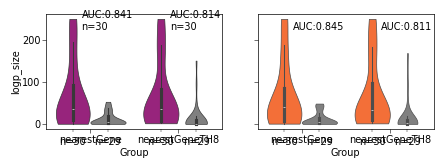

In [344]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(5,1.5), sharey=True)  
a = plot_pair_auc(ng_th, ng_th_df, ax=ax1, group='sum', stat='logp_size', group_col='Norm', group2_col='Group', color='#97247C', text_p=False, text_n=True)
plot_pair_auc(ng_th, ng_th_df, ax=ax2, group='binary', stat='logp_size', group_col='Norm', group2_col='Group', color='#F36F38')


## Identify threholds based on FDR

In [377]:
fdr_df = all_df[(all_df.Norm=='sum')].dropna()

In [378]:
fdr_df = fdr_df.sort_values(by='SizeOE', ascending=False)
fdr = []
val = []
fp = 0
tp = 0
for row in fdr_df.iterrows():
    if row[1]['Set'] == 'Test':
        tp +=1
    else:
        fp +=1
    fdr.append(fp / (fp+tp))
    val.append(row[1]['SizeOE'])


In [402]:
fdr_df['directed_p'] = fdr_df.apply(lambda z: z['logp_size'] if z.SizeOE>=0 else -1* z.logp_size, axis=1)

In [380]:
from sklearn.metrics import roc_auc_score

In [381]:
roc_auc_score(y_true=fdr_df.Set=='Test', y_score=fdr_df.SizeOE)

0.8394424367578731

In [382]:
roc_auc_score(y_true=fdr_df.Set=='Test', y_score=fdr_df.logp_size)

0.8298547090493399

In [383]:
roc_auc_score(y_true=fdr_df.Set=='Test', y_score=fdr_df.directed_p)

0.8368242495759275

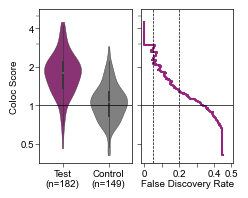

In [434]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(2.5, 2), sharey=True, gridspec_kw={'wspace':0.1})
sns.violinplot(fdr_df, x='Set', y='SizeOE', hue='Set', ax=ax1, cut=0, palette=['#97247C', 'grey'])
ax1.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5)
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylabel('Coloc Score')
_ = ax1.set_yticks([-1, 0,  1, 2], [0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6,7]), minor=True)

fdr_df = fdr_df.sort_values(by='SizeOE', ascending=False)
fdr = []
val = []
count_tp = []
sensitivity =[]
fp = 0
tp = 0
total_pos = fdr_df[fdr_df.Norm=='sum'].Set.value_counts()['Test']
for row in fdr_df.iterrows():
    if row[1]['Set'] == 'Test':
        tp +=1
    else:
        fp +=1
    count_tp.append(tp)
    fdr.append(fp / (fp+tp))
    val.append(row[1]['SizeOE'])
    sensitivity.append(tp/(total_pos))
    val

#_,  [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))
ax2.plot(fdr, val, color="#97247C", drawstyle="steps-post")
ax2.set_xlabel('False Discovery Rate')
_ = ax2.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], labels=[0, '', 0.2, '', 0.4, 0.5])



ax1.set_xticks([0,1], labels=[f'{s}\n(n={fdr_df.Set.value_counts()[s]})' for s in ['Test', 'Control']])
ax1.set_xlabel('')
ax2.vlines(x=[0.05, 0.2], ymin=-1.5, ymax=2.5, linestyle='--', color='black', linewidth=0.5)
ax2.hlines(y=0, xmin=-0.1, xmax=0.52, color='black', linewidth=0.5)
ax2.hlines(y=np.log2(1.3), xmin=-0.1, xmax=0.52, color='grey', linewidth=0.5)
ax2.hlines(y=np.log2(2.5) xmin=-0.1, xmax=0.52, color='grey', linewidth=0.5)
ax2.set_xlim(-0.02, 0.51)
ax2.set_ylim(-1.5, 2.5)
#sns.lineplot(pd.DataFrame({'x':fdr, 'y':val}),x='x', y='y', ax=ax2, markers=True)
#sns.lineplot(pd.DataFrame({'x':val, 'y':sensitivity}),x='x', y='y', ax=ax2)
#sns.lineplot(pd.DataFrame({'x':val, 'y':count_tp}),x='x', y='y', ax=ax2)    
plt.savefig(os.path.join(figdir, 'violin_plus_fdr.svg'), bbox_inches='tight')

In [432]:
print('Low value:', 2**(val[[i for i in range(len(fdr)) if fdr[i] > 0.20][0]]))
print('High value:',2**(val[[i for i in range(len(fdr)) if fdr[i] > 0.05][0]]))

Low value: 1.2970331939757214
High value: 2.898462752477351


In [ ]:
2.5, 1.3?

In [401]:
fdr_df.columns

Index(['TraitR', 'TraitC', 'Network', 'Transform', 'Norm', 'Mean_NPS',
       'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size', 'Group',
       'logp_nps', 'logp_size', 'SizeOE', 'Set', 'FullTrait', 'CleanTrait',
       'StudyR', 'StudyC', 'EFOR', 'EFOC', 'testID', 'directed_p'],
      dtype='object')

(-0.02, 0.51)

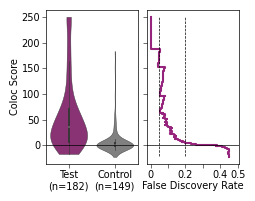

In [406]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(2.5, 2), sharey=True, gridspec_kw={'wspace':0.1})
sns.violinplot(fdr_df, x='Set', y='directed_p', hue='Set', ax=ax1, cut=0, palette=['#97247C', 'grey'])
ax1.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5)
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylabel('Coloc Score')
#_ = ax1.set_yticks([-1, 0,  1, 2], [0.5, 1, 2, 4])
#_ = ax1.set_yticks(np.log2([3,5,6,7]), minor=True)

fdr_df = fdr_df.sort_values(by='directed_p', ascending=False)
fdr = []
val = []
count_tp = []
sensitivity =[]
fp = 0
tp = 0
total_pos = fdr_df[fdr_df.Norm=='sum'].Set.value_counts()['Test']
for row in fdr_df.iterrows():
    if row[1]['Set'] == 'Test':
        tp +=1
    else:
        fp +=1
    count_tp.append(tp)
    fdr.append(fp / (fp+tp))
    val.append(row[1]['directed_p'])
    sensitivity.append(tp/(total_pos))
    val

#_,  [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))
ax2.plot(fdr, val, color="#97247C", drawstyle="steps-post")
ax2.set_xlabel('False Discovery Rate')
_ = ax2.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], labels=[0, '', 0.2, '', 0.4, 0.5])



ax1.set_xticks([0,1], labels=[f'{s}\n(n={fdr_df.Set.value_counts()[s]})' for s in ['Test', 'Control']])
ax1.set_xlabel('')
ax2.vlines(x=[0.05, 0.2], ymin=-20, ymax=250, linestyle='--', color='black', linewidth=0.5)
ax2.hlines(y=0, xmin=-0.1, xmax=0.52, color='black', linewidth=0.5)
ax2.set_xlim(-0.02, 0.51)
#ax2.set_ylim(-1.5, 2.5)
#sns.lineplot(pd.DataFrame({'x':fdr, 'y':val}),x='x', y='y', ax=ax2, markers=True)
#sns.lineplot(pd.DataFrame({'x':val, 'y':sensitivity}),x='x', y='y', ax=ax2)
#sns.lineplot(pd.DataFrame({'x':val, 'y':count_tp}),x='x', y='y', ax=ax2)    
#plt.savefig(os.path.join(figdir, 'violin_plus_fdr.svg'), bbox_inches='tight')

In [427]:
print('Low value:', val[[i for i in range(len(fdr)) if fdr[i] > 0.20][0]])
print('High value:', val[[i for i in range(len(fdr)) if fdr[i] > 0.05][0]])

Low value: 4.6302277114030375
High value: 183.45954538632859


In [424]:
np.log10(0.00005)

-4.301029995663981

In [428]:
0.00005 * 300

0.015000000000000001

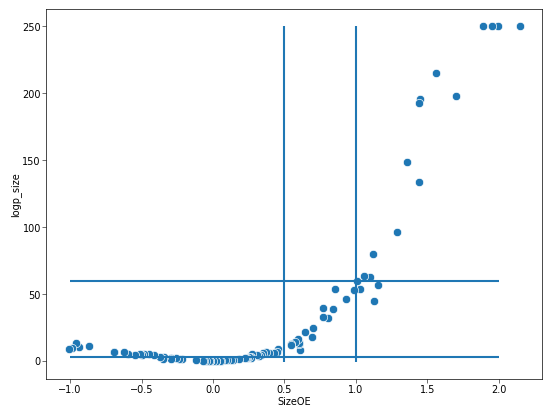

In [53]:
sns.scatterplot(fdr_df, x='SizeOE', y='logp_size')
plt.vlines(x = [0.5, 1], ymin=-1, ymax=250)
plt.hlines(y= [3, 60], xmin=-1, xmax=2)

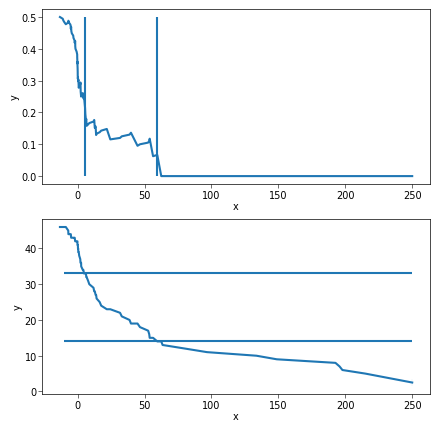

In [54]:
fdr_df = fdr_df.sort_values(by='directed_p', ascending=False)
fdr = []
val = []
count_tp = []
fp = 0
tp = 0
for row in fdr_df.iterrows():
    if row[1]['Set'] == 'Test':
        tp +=1
    else:
        fp +=1
    count_tp.append(tp)
    fdr.append(fp / (fp+tp))
    val.append(row[1]['directed_p'])

_,  [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))
sns.lineplot(pd.DataFrame({'x':val, 'y':fdr}),x='x', y='y', ax=ax1)
sns.lineplot(pd.DataFrame({'x':val, 'y':count_tp}),x='x', y='y', ax=ax2)
#ax1.hlines(y=0.2, xmin=0, xmax=260)
#ax2.hlines(y=40, xmin=0, xmax=260)

ax1.vlines(x= val[[i for i in range(len(fdr)) if fdr[i] > 0.20][0]], ymin=0, ymax=0.5 )
ax1.vlines(x= val[[i for i in range(len(fdr)) if fdr[i] > 0.05][0]], ymin=0, ymax=0.5 )
ax2.hlines(y= count_tp[[i for i in range(len(fdr)) if fdr[i] > 0.20][0]], xmin=-10, xmax=250 )
ax2.hlines(y= count_tp[[i for i in range(len(fdr)) if fdr[i] > 0.05][0]], xmin=-10, xmax=250 )

In [55]:
print('Low value:', val[[i for i in range(len(fdr)) if fdr[i] > 0.2][0]])
print('High value:', val[[i for i in range(len(fdr)) if fdr[i] > 0.05][0]])

Low value: 5.578889870206566
High value: 59.52695119491146


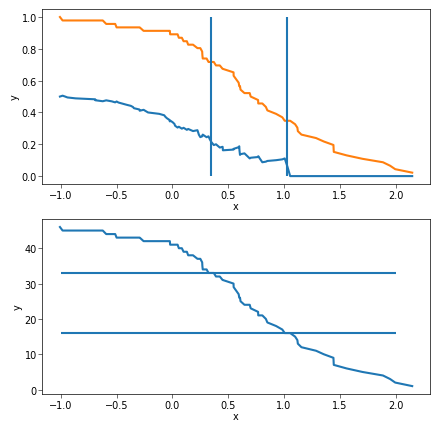

In [56]:
fdr_df = fdr_df.sort_values(by='SizeOE', ascending=False)
fdr = []
val = []
count_tp = []
sensitivity =[]
fp = 0
tp = 0
total_pos = fdr_df[fdr_df.Norm=='sum'].Set.value_counts()['Test']
for row in fdr_df.iterrows():
    if row[1]['Set'] == 'Test':
        tp +=1
    else:
        fp +=1
    count_tp.append(tp)
    fdr.append(fp / (fp+tp))
    val.append(row[1]['SizeOE'])
    sensitivity.append(tp/(total_pos))
    val

_,  [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))
sns.lineplot(pd.DataFrame({'x':val, 'y':fdr}),x='x', y='y', ax=ax1)
sns.lineplot(pd.DataFrame({'x':val, 'y':sensitivity}),x='x', y='y', ax=ax1)
sns.lineplot(pd.DataFrame({'x':val, 'y':count_tp}),x='x', y='y', ax=ax2)    
#ax1.hlines(y=0.05, xmin=-1, xmax=2)
#ax2.hlines(y=35, xmin=-1, xmax=2)

ax1.vlines(x= val[[i for i in range(len(fdr)) if fdr[i] > 0.2][0]], ymin=0, ymax=1 )
ax1.vlines(x= val[[i for i in range(len(fdr)) if fdr[i] > 0.05][0]], ymin=0, ymax=1 )
ax2.hlines(y= count_tp[[i for i in range(len(fdr)) if fdr[i] > 0.2][0]], xmin=-1, xmax=2)
ax2.hlines(y= count_tp[[i for i in range(len(fdr)) if fdr[i] > 0.05][0]], xmin=-1, xmax=2)

In [57]:
print('Low value:', val[[i for i in range(len(fdr)) if fdr[i] > 0.20][0]])
print('High value:',val[[i for i in range(len(fdr)) if fdr[i] > 0.05][0]])

Low value: 0.3488944409243706
High value: 1.0310403369413843


<Axes: xlabel='x', ylabel='y'>

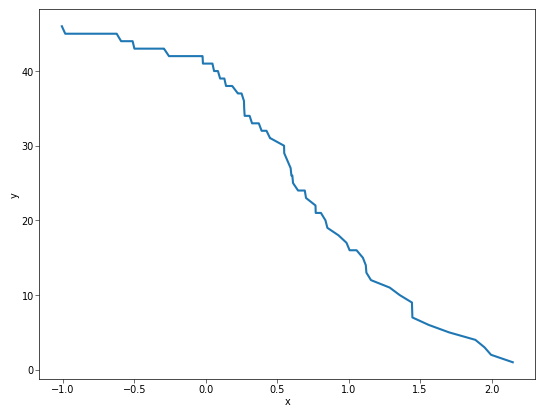

In [58]:
sns.lineplot(pd.DataFrame({'x':val, 'y':count_tp}),x='x', y='y')

In [60]:
row[1]

TraitR                        nearestGene_EFO_0009397_GCST90267931
TraitC                        nearestGene_EFO_0009397_GCST90267931
Network                                                   pcnet2_0
Transform                                                 neglog10
Norm                                                           sum
Mean_NPS                                                 -0.081031
Null_mean_NPS                                             0.001753
P_mean_NPS                                                     0.0
Size                                                            65
Null_Size                                                  130.665
P_size                                                         0.0
Group                                                  nearestGene
logp_nps                                                 44.973058
logp_size                                                 8.801618
SizeOE                                                   -1.00

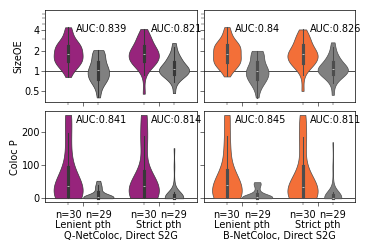

In [350]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(4,2.5), sharey='row', sharex=True, 
                                          gridspec_kw={'wspace':0.05, 'hspace':0.1})    

a = plot_pair_auc(ng_th, ng_th_df, ax=ax1, group='sum', stat='SizeOE', group_col='Norm', group2_col='Group', color='#97247C')
plot_pair_auc(ng_th, ng_th_df, ax=ax2, group='binary', stat='SizeOE', group_col='Norm', group2_col='Group', color='#F36F38')

plot_pair_auc(ng_th, ng_th_df, ax=ax3, group='sum', stat='logp_size', group_col='Norm', group2_col='Group', color='#97247C')
plot_pair_auc(ng_th, ng_th_df, ax=ax4, group='binary', stat='logp_size', group_col='Norm', group2_col='Group', color='#F36F38')
for ax in [ax1, ax2, ax3, ax4]:
    ax.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=0)
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0,1], labels=['\nLenient pth', '\nStrict pth'])
for ax in [ax1, ax2]:
    ax.set_ylim(-1.5, 3)
    ax.set_yticks([-1, 0, 1, 2])

ax3.set_xlabel(f'Q-NetColoc, Direct S2G')
ax4.set_xlabel(f'B-NetColoc, Direct S2G')
#ax1.set_ylabel('Log2SizeOE')
ax3.set_ylabel('Coloc P')
plt.savefig(os.path.join(figdir, 'assocp_compare_ng.svg'), bbox_inches='tight')

In [364]:
ng_th[ng_th.stat.isin(['SizeOE', 'logp_size'])].groupby('stat').AUC.mean()

stat
SizeOE       0.831609
logp_size    0.827874
Name: AUC, dtype: float64

In [365]:
magma_th[magma_th.stat.isin(['SizeOE', 'logp_size'])].groupby('stat').AUC.mean()

stat
SizeOE       0.880072
logp_size    0.881028
Name: AUC, dtype: float64

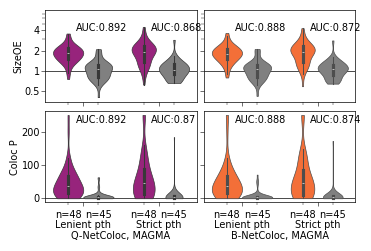

In [348]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(4,2.5), sharey='row', sharex=True, 
                                          gridspec_kw={'wspace':0.05, 'hspace':0.1})    

a = plot_pair_auc(magma_th, magma_th_df.reset_index(), ax=ax1, group='sum', stat='SizeOE', group_col='Norm', group2_col='Group', color='#97247C')
plot_pair_auc(magma_th, magma_th_df.reset_index(), ax=ax2, group='binary', stat='SizeOE', group_col='Norm', group2_col='Group', color='#F36F38')

a = plot_pair_auc(magma_th, magma_th_df.reset_index(), ax=ax3, group='sum', stat='logp_size', group_col='Norm', group2_col='Group', color='#97247C')
plot_pair_auc(magma_th, magma_th_df.reset_index(), ax=ax4, group='binary', stat='logp_size', group_col='Norm', group2_col='Group', color='#F36F38')
for ax in [ax1, ax2, ax3, ax4]:
    ax.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=0)
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0,1], labels=['\nLenient pth', '\nStrict pth'])
for ax in [ax1, ax2]:
    ax.set_ylim(-1.5, 3)
    ax.set_yticks([-1, 0, 1, 2])

ax3.set_xlabel('Q-NetColoc, MAGMA')
ax4.set_xlabel('B-NetColoc, MAGMA')
#ax1.set_ylabel('Log2SizeOE')
ax3.set_ylabel('Coloc P')
plt.savefig(os.path.join(figdir, 'assocp_compare_magma.svg'), bbox_inches='tight')

In [351]:
a

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,logp_size,SizeOE,Set,FullTrait,CleanTrait,StudyR,StudyC,EFOR,EFOC,testID
0,nearestGene_EFO_0004741_GCST008062,nearestGene_EFO_0004741_GCST008062,pcnet2_0,neglog10,sum,0.083334,0.000299,3.507000e-28,275,222.338,...,4.297311,0.306677,Test,nearestGene_EFO_0004741_GCST008062_nearestGene...,EFO_0004741_GCST008062_EFO_0004741_GCST008062,GCST008062,GCST008062,EFO_0004741,EFO_0004741,GCST008062GCST008062EFO_0004741EFO_0004741
0,nearestGene_EFO_0010821_GCST90016673,nearestGene_EFO_0010821_GCST90016673,pcnet2_0,neglog10,sum,0.431058,-0.000825,0.000000e+00,587,151.837,...,250.000000,1.950837,Test,nearestGene_EFO_0010821_GCST90016673_nearestGe...,EFO_0010821_GCST90016673_EFO_0010821_GCST90016673,GCST90016673,GCST90016673,EFO_0010821,EFO_0010821,GCST90016673GCST90016673EFO_0010821EFO_0010821
0,nearestGene_EFO_0007117_GCST90100574,nearestGene_EFO_0007117_GCST90100574,pcnet2_0,neglog10,sum,0.081672,0.008164,1.909000e-23,310,239.688,...,6.746662,0.371111,Test,nearestGene_EFO_0007117_GCST90100574_nearestGe...,EFO_0007117_GCST90100574_EFO_0007117_GCST90100574,GCST90100574,GCST90100574,EFO_0007117,EFO_0007117,GCST90100574GCST90100574EFO_0007117EFO_0007117
0,nearestGene_EFO_0004343_GCST008996,nearestGene_EFO_0004343_GCST008996,pcnet2_0,neglog10,sum,0.349866,0.001183,0.000000e+00,395,221.006,...,38.816730,0.837767,Test,nearestGene_EFO_0004343_GCST008996_nearestGene...,EFO_0004343_GCST008996_EFO_0004343_GCST008996,GCST008996,GCST008996,EFO_0004343,EFO_0004343,GCST008996GCST008996EFO_0004343EFO_0004343
0,nearestGene_EFO_0004741_GCST90103632,nearestGene_EFO_0004741_GCST90103632,pcnet2_0,neglog10,sum,0.160230,-0.000057,2.147000e-115,288,196.987,...,11.880414,0.547968,Test,nearestGene_EFO_0004741_GCST90103632_nearestGe...,EFO_0004741_GCST90103632_EFO_0004741_GCST90103632,GCST90103632,GCST90103632,EFO_0004741,EFO_0004741,GCST90103632GCST90103632EFO_0004741EFO_0004741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,nearestGeneTH8_EFO_0009397_GCST90267932,nearestGeneTH8_EFO_0021898_GCST90269581,pcnet2_0,neglog10,sum,0.049448,0.001563,2.356000e-14,221,190.501,...,2.158453,0.214248,Control,nearestGeneTH8_EFO_0009397_GCST90267932_neares...,EFO_0009397_GCST90267932_EFO_0021898_GCST90269581,GCST90267932,GCST90269581,EFO_0009397,EFO_0021898,GCST90267932GCST90269581EFO_0009397EFO_0021898
0,nearestGeneTH8_EFO_0000731_GCST90018714,nearestGeneTH8_EFO_0007117_GCST90100574,pcnet2_0,neglog10,sum,-0.016646,-0.001409,9.913000e-01,115,164.347,...,-0.000000,-0.515111,Control,nearestGeneTH8_EFO_0000731_GCST90018714_neares...,EFO_0000731_GCST90018714_EFO_0007117_GCST90100574,GCST90018714,GCST90100574,EFO_0000731,EFO_0007117,GCST90018714GCST90100574EFO_0000731EFO_0007117
0,nearestGeneTH8_EFO_0006525_GCST007459,nearestGeneTH8_EFO_0004343_GCST008997,pcnet2_0,neglog10,sum,0.073467,0.002376,1.789000e-22,169,167.548,...,0.345246,0.012449,Control,nearestGeneTH8_EFO_0006525_GCST007459_nearestG...,EFO_0006525_GCST007459_EFO_0004343_GCST008997,GCST007459,GCST008997,EFO_0006525,EFO_0004343,GCST007459GCST008997EFO_0006525EFO_0004343
0,nearestGeneTH8_EFO_0010821_GCST90267352,nearestGeneTH8_EFO_0004741_GCST90278623,pcnet2_0,neglog10,sum,0.041209,0.004128,2.430000e-07,145,181.880,...,0.000652,-0.326934,Control,nearestGeneTH8_EFO_0010821_GCST90267352_neares...,EFO_0010821_GCST90267352_EFO_0004741_GCST90278623,GCST90267352,GCST90278623,EFO_0010821,EFO_0004741,GCST90267352GCST90278623EFO_0010821EFO_0004741


## MAGMA vs NG

In [323]:
control_lists = {'nearestGene': { 'sum':2221662, 'binary':2221678},
             'magma_th104':{ 'sum': 2221690, 'binary':2221684},}
control_lists = {'nearestGene': { 'sum':2221852, 'binary':2221859},
             'magma_th104':{ 'sum': 2221866, 'binary':2221872},}
control_lists = {'nearestGene': { 'sum':2222022, 'binary':2222028},
             'magma_th104':{ 'sum': 2222034, 'binary':2222040},}
control_results = {x: {} for x in control_lists}

In [216]:
resdir

'/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/testing/'

In [324]:
not_found = []
for x, y in control_lists.items():
    print(x)
    for z,  job_id in y.items():
        if 'magma' in x:
            with open(os.path.join(resdir,'../magma', f'{job_id}.files'), 'r') as f:
                filenames = list(set([s.strip() for s in f.readlines()]))
            
            loaded_data = []
            for f in filenames:
                f = f.replace('.txt', '_bin20.txt')
                try:
                    loaded_data.append(pd.read_csv(os.path.join(resdir, '../magma', f), sep='\t', header=None))
                except FileNotFoundError:
                    try:
                        f = f.replace('_bin20.txt', '.txt')
                        loaded_data.append(pd.read_csv(os.path.join(resdir, '../magma', f), sep='\t', header=None))
                    except:
                        not_found.append(os.path.join(resdir, '../magma', f))
        else:
            with open(os.path.join(resdir, f'{job_id}.files'), 'r') as f:
                filenames = list(set([s.strip() for s in f.readlines()]))
            loaded_data = []
            for f in filenames:
                try:
                    loaded_data.append(pd.read_csv(os.path.join(resdir, f), sep='\t', header=None))
                except FileNotFoundError:
                    try:
                        f = f.replace('.txt', '_bin20.txt')
                        loaded_data.append(pd.read_csv(os.path.join(resdir, f), sep='\t', header=None))
                    except:
                        not_found.append(f)
        control_results[x][z] = pd.concat(loaded_data)
        control_results[x][z].columns = ['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 
                                 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
        control_results[x][z]['Group'] = x
        control_results[x][z]['Norm'] = z
        control_results[x][z]['logp_nps'] = control_results[x][z].P_mean_NPS.apply(lambda x: -1 * np.log10(x+1e-250))
        control_results[x][z]['logp_size'] = control_results[x][z].P_size.apply(lambda x: -1 * np.log10(x+1e-250))
        control_results[x][z]['SizeOE'] = np.log2(control_results[x][z]['Size'] / control_results[x][z]['Null_Size'])
        control_results[x][z]['Set'] = 'Control'
        control_results[x][z]['FullTrait'] = control_results[x][z].apply(lambda a: '_'.join([a.TraitR, a.TraitC]), axis=1)

nearestGene
magma_th104


In [325]:
ng_cont2 = pd.concat(control_results['nearestGene'].values())
mag104_cont2 = pd.concat(control_results['magma_th104'].values())

In [326]:
all_df2 = pd.concat([ng, mag104,ng_cont2, mag104_cont2])

In [327]:
all_df2['CleanTrait'] = all_df2.apply(lambda x: '_'.join([clean_trait(x.TraitR), clean_trait(x.TraitC)]), axis=1)
all_df2['StudyR'] = all_df2.TraitR.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
all_df2['StudyC'] = all_df2.TraitC.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
all_df2['EFOR'] = all_df2.TraitR.apply(lambda x: map_trait_code(x))
all_df2['EFOC'] = all_df2.TraitC.apply(lambda x: map_trait_code(x))
all_df2['testID'] = all_df2['StudyR'] + all_df2['StudyC'] + all_df2['EFOR'] + all_df2['EFOC']

In [328]:
x_th, x_th_df = pair_auc(all_df2[all_df2.Group == 'nearestGene'], all_df2[all_df2.Group == 'magma_th104'])

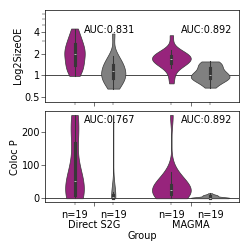

In [347]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5,2.5), sharey='row', sharex=True, gridspec_kw={'hspace':0.1})    
plot_pair_auc(x_th, x_th_df,ax=ax1, group='sum', stat='SizeOE', group_col='Norm', group2_col='Group', color='#97247C')
plot_pair_auc(x_th, x_th_df,ax=ax2, group='sum', stat='logp_size', group_col='Norm', group2_col='Group', color='#97247C')
for ax in [ax1, ax2]:
    ax.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=0)
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0,1], labels=['\nDirect S2G', '\nMAGMA'])
ax1.set_ylabel('Log2SizeOE')
ax1.set_ylim(-1.2, 3)
ax1.set_yticks([-1, 0,1,2])
ax2.set_ylabel('Coloc P')
plt.savefig(os.path.join(figdir, 'ng_vs_magma.svg'), bbox_inches='tight')

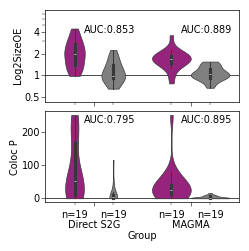

In [305]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5,2.5), sharey='row', sharex=True, gridspec_kw={'hspace':0.1})    
plot_pair_auc(x_th, x_th_df,ax=ax1, group='sum', stat='SizeOE', group_col='Norm', group2_col='Group', color='#97247C')
plot_pair_auc(x_th, x_th_df,ax=ax2, group='sum', stat='logp_size', group_col='Norm', group2_col='Group', color='#97247C')
for ax in [ax1, ax2]:
    ax.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=0)
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0,1], labels=['\nDirect S2G', '\nMAGMA'])
ax1.set_ylabel('Log2SizeOE')
ax1.set_ylim(-1.2, 3)
ax1.set_yticks([-1, 0,1,2])
ax2.set_ylabel('Coloc P')
plt.savefig(os.path.join(figdir, 'ng_vs_magma.svg'), bbox_inches='tight')

In [330]:
x_th_df[x_th_df.Set=='Control'].sort_values('SizeOE', ascending=False)

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,logp_size,SizeOE,Set,FullTrait,CleanTrait,StudyR,StudyC,EFOR,EFOC,testID
0,nearestGene_EFO_0008036_GCST90094960,nearestGene_EFO_0010821_GCST90267352,pcnet2_0,neglog10,binary,0.501603,-0.001785,0.000000e+00,648,170.592,...,250.000000,1.925444,Control,nearestGene_EFO_0008036_GCST90094960_nearestGe...,EFO_0008036_GCST90094960_EFO_0010821_GCST90267352,GCST90094960,GCST90267352,EFO_0008036,EFO_0010821,GCST90094960GCST90267352EFO_0008036EFO_0010821
0,nearestGene_EFO_0008036_GCST90094960,nearestGene_EFO_0010821_GCST90267352,pcnet2_0,neglog10,sum,0.514784,-0.002632,0.000000e+00,706,186.935,...,250.000000,1.917131,Control,nearestGene_EFO_0008036_GCST90094960_nearestGe...,EFO_0008036_GCST90094960_EFO_0010821_GCST90267352,GCST90094960,GCST90267352,EFO_0008036,EFO_0010821,GCST90094960GCST90267352EFO_0008036EFO_0010821
0,nearestGene_EFO_0004343_GCST90278649,nearestGene_EFO_0005213_GCST009414,pcnet2_0,neglog10,binary,0.115252,0.003877,8.469000e-53,463,247.734,...,53.611011,0.902220,Control,nearestGene_EFO_0004343_GCST90278649_nearestGe...,EFO_0004343_GCST90278649_EFO_0005213_GCST009414,GCST90278649,GCST009414,EFO_0004343,EFO_0005213,GCST90278649GCST009414EFO_0004343EFO_0005213
0,nearestGene_EFO_0006525_GCST90179151,nearestGene_EFO_0010821_GCST90016673,pcnet2_0,neglog10,sum,0.220362,-0.003873,1.113000e-226,312,167.943,...,33.669789,0.893574,Control,nearestGene_EFO_0006525_GCST90179151_nearestGe...,EFO_0006525_GCST90179151_EFO_0010821_GCST90016673,GCST90179151,GCST90016673,EFO_0006525,EFO_0010821,GCST90179151GCST90016673EFO_0006525EFO_0010821
0,nearestGene_EFO_0006525_GCST90179151,nearestGene_EFO_0010821_GCST90016673,pcnet2_0,neglog10,binary,0.216210,-0.004634,7.213000e-239,308,166.928,...,32.833570,0.883704,Control,nearestGene_EFO_0006525_GCST90179151_nearestGe...,EFO_0006525_GCST90179151_EFO_0010821_GCST90016673,GCST90179151,GCST90016673,EFO_0006525,EFO_0010821,GCST90179151GCST90016673EFO_0006525EFO_0010821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,nearestGene_EFO_0004741_GCST008062,nearestGene_EFO_0004237_GCST90018627,pcnet2_0,neglog10,binary,-0.090133,-0.000067,3.621000e-41,112,164.513,...,5.377682,-0.554703,Control,nearestGene_EFO_0004741_GCST008062_nearestGene...,EFO_0004741_GCST008062_EFO_0004237_GCST90018627,GCST008062,GCST90018627,EFO_0004741,EFO_0004237,GCST008062GCST90018627EFO_0004741EFO_0004237
0,nearestGene_EFO_0007117_GCST90092502,nearestGene_EFO_0004741_GCST008062,pcnet2_0,neglog10,binary,-0.080844,0.003430,2.880000e-28,171,251.408,...,7.569280,-0.556034,Control,nearestGene_EFO_0007117_GCST90092502_nearestGe...,EFO_0007117_GCST90092502_EFO_0004741_GCST008062,GCST90092502,GCST008062,EFO_0007117,EFO_0004741,GCST90092502GCST008062EFO_0007117EFO_0004741
0,magma_th104_GCST008062_EFO_0004741,magma_th104_GCST90018627_EFO_0004237,pcnet2_0,neglog10,sum,-0.068989,0.009390,3.444000e-17,137,201.759,...,6.692718,-0.558457,Control,magma_th104_GCST008062_EFO_0004741_magma_th104...,GCST008062_EFO_0004741_GCST90018627_EFO_0004237,GCST008062,GCST90018627,EFO_0004741,EFO_0004237,GCST008062GCST90018627EFO_0004741EFO_0004237
0,nearestGene_EFO_0007117_GCST90092502,nearestGene_EFO_0004741_GCST008062,pcnet2_0,neglog10,sum,-0.078502,0.002708,7.613000e-29,166,248.821,...,8.327348,-0.583925,Control,nearestGene_EFO_0007117_GCST90092502_nearestGe...,EFO_0007117_GCST90092502_EFO_0004741_GCST008062,GCST90092502,GCST008062,EFO_0007117,EFO_0004741,GCST90092502GCST008062EFO_0007117EFO_0004741
